In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import random
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy.stats import entropy
import networkit as nk #more efficient
import pickle
import statistics
from sklearn.utils import shuffle
from scipy.stats import pearsonr, spearmanr

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,time_series_henColumn_tsRow, is_WG_open, is_day
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_tracking_date = config.li_tracking_date
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'LongformatModels')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
EXP2_


In [4]:
path_extracted_data

'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_'

In [5]:
#with weight on the edge: TODO AND READ
#https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html

# download data

In [6]:
#new data
df_exp12 = pd.read_csv(os.path.join(path_extracted_data, 'df_bothexperiment.csv'), sep=',',
                         parse_dates=['level'], dayfirst=True) 
print(df_exp12.columns)
#keep only the HA from the corresponding timestamps
df_exp12['severity'] = df_exp12.apply(lambda x: x[x['HAID']+'_severity'], axis=1)
df_exp12['gap'] = df_exp12.apply(lambda x: x[x['HAID']+'_gap'], axis=1)
df_exp12['weight'] = df_exp12.apply(lambda x: x[x['HAID']+'_weight'], axis=1)
df_exp12['IsOFH'] = df_exp12['Treatment'].map(lambda x: x=='OFH')
display(df_exp12[['HA1_severity', 'HA2_severity','HA3_severity', 'HA4_severity','HA5_severity','severity','HAID']])
print(df_exp12.shape)
display(df_exp12.head(3))

Index(['DOA', 'Period_type', 'PenID', 'Is_relocated', 'time2event', 'level',
       'early_death', 'HenID', 'RPenID', 'Is2Experiment', 'Treatment',
       'mid_cum_Z4_h_Morning', 'WentinWG', 'Total_number_transition',
       'nbr_stays_1_Zone', 'vertical_travel_distance', 'duration_1_Zone_min',
       'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min',
       'duration_5_Zone_min', 'nbr_h_WGopen', 'HA1_weight', 'HA2_weight',
       'HA3_weight', 'HA4_weight', 'HA1_severity', 'HA2_severity',
       'HA3_severity', 'HA4_severity', 'HA1_gap', 'HA2_gap', 'HA3_gap',
       'HA4_gap', 'HA1_FeatherDamage', 'HA2_FeatherDamage',
       'HA3_FeatherDamage', 'HA4_FeatherDamage', 'ExperimentID',
       'daytimeduration', 'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight',
       'HA5_gap', 'HAID', 'VTDperhour', 'Total_number_indoor_transition',
       'zonecrossed2transition'],
      dtype='object')


,HA1_severity,HA2_severity,HA3_severity,HA4_severity,HA5_severity,severity,HAID
0,0.0,0.0,1.0,18.0,NaN,0.0,HA1
1,0.0,0.0,1.0,18.0,NaN,0.0,HA1
2,0.0,0.0,1.0,18.0,NaN,0.0,HA1
3,0.0,0.0,1.0,18.0,NaN,0.0,HA1
4,0.0,0.0,1.0,18.0,NaN,0.0,HA1
...,...,...,...,...,...,...,...
8381,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8382,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8383,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8384,14.0,20.0,14.0,16.0,32.0,32.0,HA5


(8386, 52)


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Is2Experiment,...,HA5_weight,HA5_gap,HAID,VTDperhour,Total_number_indoor_transition,zonecrossed2transition,severity,gap,weight,IsOFH
0,167,R1,pen10,1,7,2021-11-23,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,HA1,3.185185,43.0,1.000000,0.0,0.0,1691.7,False
1,168,R1,pen10,1,6,2021-11-24,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,HA1,3.555556,45.0,1.066667,0.0,0.0,1691.7,False
2,169,R1,pen10,1,5,2021-11-25,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,HA1,4.592593,62.0,1.000000,0.0,0.0,1691.7,False


Index(['timepoint', 'group', 'age', 'day', 'date', 'file', 'pen', 'hybrid',
       'hen', 'severity', 'gap', 'durationC1', 'durationC2', 'durationC3',
       'durationC4', 'durationC5', 'durationC14', 'numberC1', 'numberC2',
       'numberC3', 'numberC4', 'numberC5', 'meanboutM1', 'medianboutM1',
       'meanboutM2', 'medianboutM2', 'meanboutM3', 'medianboutM3',
       'meanboutM4', 'medianboutM4', 'meanboutM5', 'medianboutM5', 'distance',
       'meanchange', 'mean1', 'medianchange', 'transitions', 'real0', 'sumdur',
       'nest_vs_total', 'PenID'],
      dtype='object')

pen1    1320
pen3    1320
pen5    1320
pen2    1320
pen4    1320
pen6    1320
Name: PenID, dtype: int64

pen5    1320
pen4    1320
pen6    1320
Name: PenID, dtype: int64

(3960, 51)


,timepoint,group,age,day,date,file,pen,hybrid,hen,severity,...,HenID,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,daytimeduration,ExperimentID,VTDperhour,Treatment
240,1,A,21,1,2016-10-27,1A41,5,LB,41,35.0,...,EXP3_hen_41,175.683333,96.783333,614.100000,70.800000,0.00,16,Exp3,2.875,groupA
241,1,A,21,2,2016-10-28,1A41,5,LB,41,35.0,...,EXP3_hen_41,68.633333,205.733333,632.333333,52.166667,0.35,16,Exp3,4.000,groupA
242,1,A,21,3,2016-10-29,1A41,5,LB,41,35.0,...,EXP3_hen_41,174.600000,124.483333,604.016667,53.633333,0.00,16,Exp3,3.625,groupA


,DOA,age,date,group
240,142,21,2016-10-27,A
241,143,21,2016-10-28,A
242,144,21,2016-10-29,A
243,145,21,2016-10-30,A
244,146,21,2016-10-31,A
...,...,...,...,...
7915,432,62,2017-08-13,B
7916,433,62,2017-08-14,B
7917,434,62,2017-08-15,B
7918,435,62,2017-08-16,B


,durationC1
count,131.000000
mean,5976.497273
std,1521.929290
min,0.000000
25%,5152.014161
50%,6303.025000
75%,6945.160294
max,9744.052632


,date,durationC1
47,2017-01-18,0.0


(3960, 56)
(3920, 56)


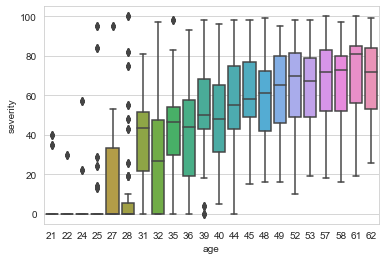

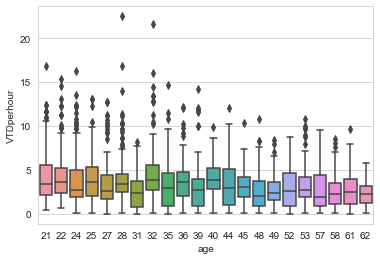

In [7]:
#past experiment
df_exp3 = pd.read_excel(os.path.join(path_extracted_data,'Mo_Masterfile.xlsx'),index_col=False,
                        parse_dates=['date'])
df_exp3['PenID'] = df_exp3['pen'].map(lambda x: 'pen'+str(x))
display(df_exp3.columns)
#check penID
display(df_exp3['PenID'].value_counts())
df_exp3 = df_exp3[df_exp3['hybrid']=='LB']
display(df_exp3['PenID'].value_counts())
df_exp3['HenID'] = df_exp3['hen'].map(lambda x: 'EXP3_hen_'+str(x))
df_exp3['severity'] = df_exp3['severity'].map(lambda x: x*10) #scale as in our experiment
df_exp3['duration_1_Zone_min'] = df_exp3['durationC1'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_2_Zone_min'] = df_exp3['durationC2'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_3_Zone_min'] = df_exp3['durationC3'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_4_Zone_min'] = df_exp3['durationC4'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_5_Zone_min'] = df_exp3['durationC5'].map(lambda x: x/60) #scale as in our experiment

df_exp3['daytimeduration'] = 16
df_exp3['ExperimentID'] = 'Exp3'
df_exp3['VTDperhour'] = df_exp3['distance'] /df_exp3['daytimeduration']
#df_exp3['proptime_2_Zone'] = df_exp3['duration_2_Zone_min'] / (df_exp3['daytimeduration']*60) *100
#df_exp3['proptime_5_Zone'] = df_exp3['duration_5_Zone_min'] / (df_exp3['daytimeduration']*60) *100
df_exp3['Treatment'] = df_exp3['group'].map(lambda x: 'group'+x)
print(df_exp3.shape)
#display(df_exp3[['daytimeduration','distance','VTDperhour','group',
#                 'duration_2_Zone_min','duration_5_Zone_min']].head(3))

#extract DOA (instead of the age here beeing weeks of age)
display(df_exp3.head(3))
df_exp3[df_exp3['age']==21]['date'].unique() 
#if hens were 21 week of age during these 6 days, lets assume they became 21WOA on the previous day : 
#dt.datetime(2016,10,26) hens were 141
#BUT BETTER: ask Rufener if she knows
df_exp3['DOA'] = df_exp3['date'].map(lambda x: int(141+(x-dt.datetime(2016,10,26)).days))
display(df_exp3[['DOA','age','date','group']])

df_exp3['early_death'] = 0 #to check with Christina
df_exp3['time2event'] = df_exp3['day'].map(lambda x: 7-x)
df_exp3['IsOFH'] = 0
df_exp3['Is_relocated'] = 0

df_exp3.rename(columns={'timepoint':'HAID','transitions':'Total_number_transition','meanchange':'zonecrossed2transition'}, inplace=True)
df_exp3['HAID'] = df_exp3['HAID'].map(lambda x: 'HA'+str(int(x)))
df_exp3['HAID'] = df_exp3.apply(lambda x: x['HAID']+x['group'], axis=1)

#remove that day as no bird went outside on that day... WG was certainly close which will influecne the mvt 
df_ = df_exp3.groupby('date')['durationC1'].mean().reset_index()
display(df_.describe())
display(df_[df_['durationC1']<1000])
print(df_exp3.shape)
df_exp3 = df_exp3[df_exp3['date']!=dt.datetime(2017,1,18)]
print(df_exp3.shape)

sns.boxplot(x='age',y='severity', data=df_exp3)
plt.show();
sns.boxplot(x='age',y='VTDperhour', data=df_exp3)
plt.show();

In [8]:
df_haage = df_exp3.groupby(['HAID'])['DOA'].agg(lambda x: max(set(x))+1).reset_index() #KBF done on the day after
df_haage['HAID'] = df_haage['HAID'].map(lambda x: 'Exp3_'+x)
display(df_haage)
dico_haexp3_age = dict(zip(df_haage['HAID'].tolist(),df_haage['DOA'].tolist()))
dico_haexp3_age

,HAID,DOA
0,Exp3_HA10A,400
1,Exp3_HA10B,409
2,Exp3_HA11A,428
3,Exp3_HA11B,437
4,Exp3_HA1A,148
5,Exp3_HA1B,156
6,Exp3_HA2A,169
7,Exp3_HA2B,177
8,Exp3_HA3A,190
9,Exp3_HA3B,198


{'Exp3_HA10A': 400,
 'Exp3_HA10B': 409,
 'Exp3_HA11A': 428,
 'Exp3_HA11B': 437,
 'Exp3_HA1A': 148,
 'Exp3_HA1B': 156,
 'Exp3_HA2A': 169,
 'Exp3_HA2B': 177,
 'Exp3_HA3A': 190,
 'Exp3_HA3B': 198,
 'Exp3_HA4A': 218,
 'Exp3_HA4B': 225,
 'Exp3_HA5A': 246,
 'Exp3_HA5B': 254,
 'Exp3_HA6A': 274,
 'Exp3_HA6B': 282,
 'Exp3_HA7A': 317,
 'Exp3_HA7B': 325,
 'Exp3_HA8A': 337,
 'Exp3_HA8B': 345,
 'Exp3_HA9A': 365,
 'Exp3_HA9B': 373}

In [9]:
#exp2
birth_date = dt.datetime(2021,6,9) #DOA 1 = 2021-6-10
li_ = [dt.datetime(2021,11,30), dt.datetime(2022,2,8), dt.datetime(2022,4,12), dt.datetime(2022,7,5)]
print([(i-birth_date).days for i in li_])
#exp1:
birth_date = dt.datetime(2020,6,3) #DOA 1 = 2020-6-4
li_ = [dt.datetime(2020,11,23), dt.datetime(2021,1,4), dt.datetime(2021,2,1),
               dt.datetime(2021,4,12), dt.datetime(2021,7,26)]
print([(i-birth_date).days for i in li_])

dico_haexp12_age = {'Exp2_HA1': 174,'Exp2_HA2': 244,'Exp2_HA3': 307,'Exp2_HA4': 391,
                    'Exp1_HA1':173, 'Exp1_HA2':215,'Exp1_HA3':243,'Exp1_HA4':313,'Exp1_HA5':418}
dico_ha_age = {**dico_haexp3_age, **dico_haexp12_age}
dico_ha_age
#lets define start date of study as 215, to inlude four timestamp from the studies, except exp 1 as to much correlated with time 
doa_studystarted = min(dico_ha_age.values()) #lets consider all #for now 190
doa_studystarted

[174, 244, 307, 391]
[173, 215, 243, 313, 418]


148

In [10]:
print(min(dico_ha_age.values()),max(dico_ha_age.values()),
      round(np.mean(list(dico_ha_age.values())),2),np.median(list(dico_ha_age.values())))

148 437 282.29 274.0


#what is durationC14
df_exp3['test'] = df_exp3[['durationC1','durationC2','durationC3','durationC4']].sum(axis=1)
display(df_exp3[[i for i in df_exp3.columns if 'duration' in i]+['test']])
df_exp3[df_exp3['test2']!=df_exp3['durationC14']] #wohoooo thats what it is

# combine together

In [11]:
df_exp12.columns

Index(['DOA', 'Period_type', 'PenID', 'Is_relocated', 'time2event', 'level',
       'early_death', 'HenID', 'RPenID', 'Is2Experiment', 'Treatment',
       'mid_cum_Z4_h_Morning', 'WentinWG', 'Total_number_transition',
       'nbr_stays_1_Zone', 'vertical_travel_distance', 'duration_1_Zone_min',
       'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min',
       'duration_5_Zone_min', 'nbr_h_WGopen', 'HA1_weight', 'HA2_weight',
       'HA3_weight', 'HA4_weight', 'HA1_severity', 'HA2_severity',
       'HA3_severity', 'HA4_severity', 'HA1_gap', 'HA2_gap', 'HA3_gap',
       'HA4_gap', 'HA1_FeatherDamage', 'HA2_FeatherDamage',
       'HA3_FeatherDamage', 'HA4_FeatherDamage', 'ExperimentID',
       'daytimeduration', 'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight',
       'HA5_gap', 'HAID', 'VTDperhour', 'Total_number_indoor_transition',
       'zonecrossed2transition', 'severity', 'gap', 'weight', 'IsOFH'],
      dtype='object')

In [12]:
######################################################################################
#concat both dataset
li_mvtha = ['VTDperhour','zonecrossed2transition','severity','gap']
li_info = ['HenID','PenID','early_death','ExperimentID','DOA','time2event','HAID','Is_relocated','IsOFH','daytimeduration']
li_unevecomput = ['duration_1_Zone_min','duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min','duration_5_Zone_min']
print(df_exp12.shape)
#display(df_exp12[li_mvtha+li_info].head(2))
print(df_exp3.shape)
#display(df_exp3[li_mvtha+li_info].head(2))
df = pd.concat([df_exp12[li_mvtha+li_info+['weight']+li_unevecomput], 
                df_exp3[li_mvtha+li_info+li_unevecomput]])
print(df.shape)
display(df.head(2))

(8386, 52)
(3920, 56)
(12306, 20)


,VTDperhour,zonecrossed2transition,severity,gap,HenID,PenID,early_death,ExperimentID,DOA,time2event,HAID,Is_relocated,IsOFH,daytimeduration,weight,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min
0,3.185185,1.000000,0.0,0.0,EXP2_hen_1,pen10,0.0,Exp2,167,7,HA1,1,0,13.5,1691.7,0.0,535.966667,201.916667,55.800000,16.316667
1,3.555556,1.066667,0.0,0.0,EXP2_hen_1,pen10,0.0,Exp2,168,6,HA1,1,0,13.5,1691.7,0.0,410.600000,171.883333,53.783333,173.733333


# compute unevenness

In [13]:
print(df.shape)
df = df[~df['duration_2_Zone_min'].isnull()]
print(df.shape)

(12306, 20)
(11838, 20)


In [14]:
li_space = [3.726,16.100,5.819,2.152+1.472,4.531]
def unevenness(li_propzones,li_expected):
    '''compute the following distance: d(x,y) = sum( abs(xi-yi) / (yi) ) / n'''
    n = len(li_propzones)
    if n!=len(li_expected):
        print('your two vectors must have same length')
        sys.exit()
    #ensure the vectors are normalized (sum to 1)
    li_propzones = [i/sum(li_propzones) for i in li_propzones]
    li_expected = [i/sum(li_expected) for i in li_expected]
    d = sum([abs(li_propzones[i]-li_expected[i]) / li_expected[i] for i in range(n)])/n
    return(d)

li_propzones = [0.3,0.2,0.4,0.5,0.5]
li_propzones = [i/sum(li_propzones) for i in li_propzones]
li_normspace = [i/sum(li_space) for i in li_space]
print(li_propzones)
print(li_normspace)
lexpected = []
print(unevenness(li_propzones=li_propzones,li_expected=li_normspace))

[0.15789473684210525, 0.10526315789473685, 0.2105263157894737, 0.2631578947368421, 0.2631578947368421]
[0.11023668639053255, 0.47633136094674566, 0.1721597633136095, 0.10721893491124261, 0.13405325443786983]
0.7703348344929435


In [15]:
li_dur = [i for i in df.columns if 'duration_' in i]
print(li_dur)
df['sumdur'] = df[li_dur].sum(axis=1)
display(df[['sumdur']+li_dur].head(3))
for i in li_dur:
    df['Prop'+i.replace('duration_','Z').replace('_Zone_min','')] = df.apply(lambda x: x[i]/x['sumdur'], axis=1)
li_prop = [i for i in df.columns if i.startswith('Prop')]
display(df[li_prop].head(3))

['duration_1_Zone_min', 'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min', 'duration_5_Zone_min']


,sumdur,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min
0,810.0,0.0,535.966667,201.916667,55.800000,16.316667
1,810.0,0.0,410.600000,171.883333,53.783333,173.733333
2,810.0,0.0,478.016667,220.283333,56.600000,55.100000


,PropZ1,PropZ2,PropZ3,PropZ4,PropZ5
0,0.0,0.661687,0.249280,0.068889,0.020144
1,0.0,0.506914,0.212202,0.066399,0.214486
2,0.0,0.590144,0.271955,0.069877,0.068025


In [16]:
# to avoid that hens staying most day in the litter is treated the same as hens staying most day on the top tier,
# we will compute in terms of m^2
df['dur_values_norm'] = df.apply(lambda x: [x['PropZ1'], x['PropZ2'], x['PropZ3'], x['PropZ4'], x['PropZ5']], axis=1)
df['unevenness'] = df['dur_values_norm'].map(lambda x: unevenness(x,li_normspace))
li_mvtha = li_mvtha+['unevenness','PropZ5','PropZ2']

In [17]:
#maybe max
l1 = [0,0,0,1,0]
li_space = [3.726,16.100,5.819,2.152+1.472,4.531]
l2 = [round(i/sum(li_space),2) for i in li_space]
print(l1)
print(l2)
print(unevenness(l1,l2))

[0, 0, 0, 1, 0]
[0.11, 0.48, 0.17, 0.11, 0.13]
2.4181818181818184


In [18]:
#then drop 
print(df.shape)
df.drop([i for i in df.columns if (('durationC' in i) | ('duration_' in i))],axis=1, inplace=True)
print(df.shape)

(11838, 28)
(11838, 23)


# last processing & save

In [19]:
######################################################################################
#add usefull var
df['IsOFH'] = df['IsOFH'].map(lambda x: int(x))
df['ExperimentID'].unique() #exp1: pHD first exp, Exp2: PhD exp2, exp3: already published exp form rufener et al. (2019)
#lets mathc with the paper naming (sorted by years of data colelction)
df['Dataset1'] = df['ExperimentID'].map(lambda x: 1 if x=='Exp3' else 0) #rufener
df['Dataset2'] = df['ExperimentID'].map(lambda x: 1 if x=='Exp1' else 0) #OFH
df['Dataset3'] = df['ExperimentID'].map(lambda x: 1 if x=='Exp2' else 0) #exp2, current study
display(df[['IsOFH','ExperimentID', 'Is_relocated','Dataset1','Dataset2','Dataset3']])
df['DOAHA'] = df.apply(lambda x: dico_ha_age[x['ExperimentID']+'_'+x['HAID']], axis=1)

######################################################################################
print('---------------- remove any NA in severity of VTDperhour')
display(df.isna().sum(axis=0).sort_values())
print(df.shape)
df = df[~df['VTDperhour'].isnull()]
print(df.shape)
print(df.shape)
df = df[~df['severity'].isnull()]
print(df.shape)
display(df.isna().sum(axis=0).sort_values())

######################################################################################
print('---------------- keep all DOA >=doa_studystarted, then add MonthInStudy')
df = df[df['DOAHA']>=doa_studystarted].copy()
print(df.shape)

######################################################################################
#MonthInstudy: the time when the measurement took place (e.g., in months from the beginning of the study)
df['MonthInstudy'] = df['DOAHA'].map(lambda x: round((x-doa_studystarted)/30.4167,2))
if df['MonthInstudy'].min()!=0:
    print('error')
    sys.exit()
display(df.groupby('HenID')[['HAID','DOAHA','MonthInstudy']].agg(lambda x: sorted(set(x))).reset_index())
display(df.head(3))

,IsOFH,ExperimentID,Is_relocated,Dataset1,Dataset2,Dataset3
0,0,Exp2,1,0,0,1
1,0,Exp2,1,0,0,1
2,0,Exp2,1,0,0,1
3,0,Exp2,1,0,0,1
4,0,Exp2,1,0,0,1
...,...,...,...,...,...,...
7915,0,Exp3,0,1,0,0
7916,0,Exp3,0,1,0,0
7917,0,Exp3,0,1,0,0
7918,0,Exp3,0,1,0,0


---------------- remove any NA in severity of VTDperhour


VTDperhour                   0
Dataset2                     0
Dataset1                     0
unevenness                   0
dur_values_norm              0
PropZ5                       0
PropZ4                       0
PropZ3                       0
PropZ2                       0
PropZ1                       0
sumdur                       0
Dataset3                     0
daytimeduration              0
Is_relocated                 0
HAID                         0
time2event                   0
DOA                          0
ExperimentID                 0
early_death                  0
PenID                        0
HenID                        0
IsOFH                        0
DOAHA                        0
zonecrossed2transition      16
gap                         58
severity                    58
weight                    3569
dtype: int64

(11838, 27)
(11838, 27)
(11838, 27)
(11780, 27)


VTDperhour                   0
Dataset2                     0
Dataset1                     0
unevenness                   0
dur_values_norm              0
PropZ5                       0
PropZ4                       0
PropZ3                       0
PropZ2                       0
PropZ1                       0
sumdur                       0
Dataset3                     0
daytimeduration              0
Is_relocated                 0
HAID                         0
time2event                   0
DOA                          0
ExperimentID                 0
early_death                  0
PenID                        0
HenID                        0
gap                          0
severity                     0
IsOFH                        0
DOAHA                        0
zonecrossed2transition      16
weight                    3552
dtype: int64

---------------- keep all DOA >=doa_studystarted, then add MonthInStudy
(11780, 27)


,HenID,HAID,DOAHA,MonthInstudy
0,EXP1_hen_1,"[HA1, HA2]","[173, 215]","[0.82, 2.2]"
1,EXP1_hen_10,"[HA1, HA2, HA3, HA4, HA5]","[173, 215, 243, 313, 418]","[0.82, 2.2, 3.12, 5.42, 8.88]"
2,EXP1_hen_100,[HA1],[173],[0.82]
3,EXP1_hen_101,"[HA1, HA2, HA3, HA4, HA5]","[173, 215, 243, 313, 418]","[0.82, 2.2, 3.12, 5.42, 8.88]"
4,EXP1_hen_102,"[HA1, HA2, HA3, HA4, HA5]","[173, 215, 243, 313, 418]","[0.82, 2.2, 3.12, 5.42, 8.88]"
...,...,...,...,...
431,EXP3_hen_95,"[HA10B, HA11B, HA1B, HA2B, HA3B, HA4B, HA5B, H...","[156, 177, 198, 225, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.53, 3.48, 4.41, 5.82, 6.4..."
432,EXP3_hen_96,"[HA10B, HA1B, HA2B, HA3B, HA4B, HA5B, HA6B, HA...","[156, 177, 198, 225, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.53, 3.48, 4.41, 5.82, 6.4..."
433,EXP3_hen_97,"[HA10B, HA11B, HA1B, HA2B, HA3B, HA4B, HA5B, H...","[156, 177, 198, 225, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.53, 3.48, 4.41, 5.82, 6.4..."
434,EXP3_hen_98,"[HA10B, HA11B, HA1B, HA2B, HA3B, HA4B, HA5B, H...","[156, 177, 198, 225, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.53, 3.48, 4.41, 5.82, 6.4..."


,VTDperhour,zonecrossed2transition,severity,gap,HenID,PenID,early_death,ExperimentID,DOA,time2event,...,PropZ3,PropZ4,PropZ5,dur_values_norm,unevenness,Dataset1,Dataset2,Dataset3,DOAHA,MonthInstudy
0,3.185185,1.000000,0.0,0.0,EXP2_hen_1,pen10,0.0,Exp2,167,7,...,0.249280,0.068889,0.020144,"[0.0, 0.6616872427983539, 0.24927983539094645,...",0.608863,0,0,1,174,0.85
1,3.555556,1.066667,0.0,0.0,EXP2_hen_1,pen10,0.0,Exp2,168,6,...,0.212202,0.066399,0.214486,"[0.0, 0.5069135802469136, 0.21220164609053496,...",0.455501,0,0,1,174,0.85
2,4.592593,1.000000,0.0,0.0,EXP2_hen_1,pen10,0.0,Exp2,169,5,...,0.271955,0.069877,0.068025,"[0.0, 0.5901440329218107, 0.27195473251028807,...",0.531887,0,0,1,174,0.85


In [20]:
dico_p_pnew = {'pen11-pen12':'pen11', 'pen4-pen3':'pen4'}
df['PenIDinit'] = df['PenID'].copy()
df['PenID'] = df['PenIDinit'].map(lambda x: dico_p_pnew.get(x,x))
display(df.groupby('PenIDinit')['PenID'].value_counts())

PenIDinit    PenID
pen10        pen10    1054
pen11        pen11    1058
pen11-pen12  pen11       7
pen12        pen12     974
pen3         pen3     1086
pen4         pen4     2266
pen4-pen3    pen4        7
pen5         pen5     2186
pen6         pen6     1188
pen8         pen8      961
pen9         pen9      993
Name: PenID, dtype: int64

In [21]:
# add as first pen
df_pen = df.copy()
df_pen = df_pen.sort_values('MonthInstudy')
df_pen.groupby('HenID')['PenID'].agg(lambda x: list(x)[0]).reset_index()
dico_hen_firstpen = dict(zip(df_pen['HenID'], df_pen['PenID']))

In [23]:
df_longformat

,HAID,HenID,PenID,id,MonthInstudy,DOAHA,IsOFH,ExperimentID,Is_relocated,Dataset1,...,PropZ4,PropZ3,PropZ2,PropZ1,VTDperhour,zonecrossed2transition,unevenness,severity,gap,weight
356,created,EXP3_hen_93,pen4,1,0.00,148,0,Exp3,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,HA2B,EXP3_hen_93,pen4,1,0.95,177,0,Exp3,0,1,...,0.077633,0.174229,0.067145,0.214326,2.270833,1.056667,0.970769,0.0,0.0,NaN
1145,HA3B,EXP3_hen_93,pen4,1,1.64,198,0,Exp3,0,1,...,0.076175,0.323953,0.100821,0.131769,2.437500,1.040000,0.846872,19.0,1.0,NaN
1496,HA4B,EXP3_hen_93,pen4,1,2.53,225,0,Exp3,0,1,...,0.119666,0.269616,0.339038,0.074567,3.350000,1.004000,0.551408,10.0,0.0,NaN
1670,HA5B,EXP3_hen_93,pen4,1,3.48,254,0,Exp3,0,1,...,0.082497,0.275679,0.157388,0.157914,1.875000,1.018333,0.771722,9.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,created,EXP2_hen_1,pen9,376,0.00,148,0,Exp2,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,HA1,EXP2_hen_1,pen10,376,0.85,174,0,Exp2,1,0,...,0.060332,0.229351,0.567380,0.000000,3.680272,NaN,0.495648,0.0,0.0,1691.7
593,HA2,EXP2_hen_1,pen11,376,3.16,244,0,Exp2,1,0,...,0.036941,0.187371,0.639163,0.000000,5.142857,NaN,0.461228,0.0,0.0,1722.2
929,HA3,EXP2_hen_1,pen8,376,5.23,307,0,Exp2,1,0,...,0.062486,0.200615,0.589031,0.017891,5.112245,NaN,0.392304,1.0,0.0,1655.2


In [22]:
######################################################################################
print('---------------- remove all the hens with only one observation as we are interested in the change over time')
df_sel = df.groupby('HenID')['HAID'].agg(lambda x: len(set(x))).reset_index()
li_hen2remove = df_sel[df_sel['HAID']<=2]['HenID'].tolist() #remove all the hens with only one obs
print(len(set(li_hen2remove)))
print(df.shape)
df = df[~df['HenID'].isin(li_hen2remove)]
print(df.shape)

######################################################################################
#in ctsem documentation: "subject id (numeric values, 1 to max subjects)
print('---------------- now that we cleaned the data, lets add a subject id that comply with ctsem package in R to avoid potential confusion')
#as we will remove exp2 for one of the mvt var, lets put all those hens at the end
df_h = df[['HenID','ExperimentID']].drop_duplicates()
dico_exp_sort = {'Exp1':2,'Exp3':1, 'Exp2':3}
df_h['sort'] = df_h['ExperimentID'].map(lambda x: dico_exp_sort[x])
df_h = df_h.sort_values('sort')
df_h['id'] = range(1,df_h.shape[0]+1)
display(df_h.head(3))
display(df_h.tail(3))
dico_henID_ctsemid = dict(zip(df_h['HenID'].tolist(),df_h['id'].tolist()))
df['id'] = df['HenID'].map(lambda x: dico_henID_ctsemid[x])
display(df[['HenID','id']].head(2))
display(df[['ExperimentID','HAID']].value_counts().reset_index())
display(df[['ExperimentID','MonthInstudy']].value_counts().reset_index())

######################################################################################
print('---------------- save with mvt every day and mean mvt per HA')
print(df.shape)
display(df.head(2))
df.to_csv(os.path.join(path_extracted_data,'df_longformatALLdaily.csv'), index=False, sep=',')
print(spearmanr(df['severity'].tolist(), df['MonthInstudy'].tolist()))
print(pearsonr(df['severity'].tolist(), df['MonthInstudy'].tolist()))
#groupby occasion to have a single mean mvt behaviour per occasion (as we have a single HA per occasion, happening at the end
#of each occasion)
df_longformat = df.groupby(['HAID','HenID','PenID','id','MonthInstudy','DOAHA','IsOFH','ExperimentID', 'Is_relocated','Dataset1','Dataset2','Dataset3',
                            'early_death'])[['time2event','DOA','PropZ5','PropZ4','PropZ3','PropZ2','PropZ1','VTDperhour','zonecrossed2transition',
                                             'unevenness', 'severity','gap','weight']].mean().reset_index()
#to avoid future confusion
df_longformat.rename(columns={'DOA':'meanDOAmvt'}, inplace=True)
#check correlation --> account for age trend
print(spearmanr(df_longformat['severity'].tolist(), df_longformat['MonthInstudy'].tolist()))
print(pearsonr(df_longformat['severity'].tolist(), df_longformat['MonthInstudy'].tolist()))

####################
#We will have time reflecting age, we will create an empty observation row for every hen at the age of your earliest 
#observation -- so as not all hens had their healh assessed at doa_studystarted, we will create an observation at 148 DOA for all the 
#other hens and just set the observed variables to NA.
len(df_longformat[df_longformat['DOAHA']==doa_studystarted]['HenID'].unique())
#display(df_longformat.groupby('DOAHA')['HenID'].agg(lambda x: len(set(x))).reset_index()) #more details if we want more than 19 hens
li_firsthens = df_longformat[df_longformat['DOAHA']==doa_studystarted]['HenID'].tolist()
li_otherhens = [i for i in df_longformat['HenID'].unique() if i not in li_firsthens]
print(len(li_firsthens), len(df_longformat['HenID'].unique()), len(li_otherhens))
li_specifichens = ['HenID','id','IsOFH','ExperimentID','Is_relocated','Dataset1','Dataset2','Dataset3','early_death']
dfhens = {'HenID': li_otherhens,
          'PenID':np.nan, #as some hens changed the pen
          'MonthInstudy':0,
          'DOAHA':doa_studystarted,
          'severity':np.nan,
          'VTDperhour':np.nan,
          'PropZ5':np.nan,
          'PropZ2':np.nan,
          'unevenness':np.nan,
          'zonecrossed2transition':np.nan,
          'HAID':'created'}
df_2add = pd.DataFrame.from_dict(dfhens)
#add hens data
df_specifichens = df[li_specifichens].drop_duplicates()
if df_specifichens.shape[0]!=len(df_specifichens['HenID'].unique()):
    print('ERROR: some ind do not have unique values for at least one of the characteristics')
df_2add = pd.merge(df_2add, df_specifichens, on='HenID', how='left')
print(df_2add.shape)
display(df_2add.head(2))

print(df_longformat.shape)
df_longformat = pd.concat([df_longformat,df_2add])
print(df_longformat.shape, df_2add.shape)

#fill nan with time2event otherwise: NA's in TDpreds! Replaced by zeroes, consider appropriateness...
v = df_longformat['time2event'].mean()
print(v)
df_longformat.loc[df_longformat['time2event'].isnull(),'time2event'] = v

#groupby fucked the id, lets sort by id
df_longformat.loc[df_longformat['ExperimentID']=='Exp2','zonecrossed2transition'] = np.nan
#add penid init
df_longformat['PenID'] = df_longformat.apply(lambda x: dico_hen_firstpen[x['HenID']] if x['HAID']=='created' else x['PenID'], axis=1)
df_longformat.sort_values(['id','MonthInstudy'], inplace=True)
print(df_longformat.shape)
display(df_longformat.head(2))
df_longformat.to_csv(os.path.join(path_extracted_data,'df_longformatALL.csv'), index=False, sep=',')

#df_mzc = df_longformat[df_longformat['ExperimentID']!='Exp2'].copy()
#df_mzc.sort_values(['id','MonthInstudy'], inplace=True)
#print(df_mzc.shape)
#display(df_mzc.head(2))
#df_mzc.to_csv(os.path.join(path_extracted_data,'df_longformatALL_MZC.csv'), index=False, sep=',')

---------------- remove all the hens with only one observation as we are interested in the change over time
60
(11780, 29)
(11235, 29)
---------------- now that we cleaned the data, lets add a subject id that comply with ctsem package in R to avoid potential confusion


,HenID,ExperimentID,sort,id
1272,EXP3_hen_93,Exp3,1,1
522,EXP3_hen_88,Exp3,1,2
516,EXP3_hen_87,Exp3,1,3


,HenID,ExperimentID,sort,id
763,EXP2_hen_49,Exp2,3,374
742,EXP2_hen_46,Exp2,3,375
0,EXP2_hen_1,Exp2,3,376


,HenID,id
0,EXP2_hen_1,376
1,EXP2_hen_1,376


,ExperimentID,HAID,0
0,Exp2,HA3,1134
1,Exp2,HA1,1113
2,Exp2,HA4,1094
3,Exp1,HA1,945
4,Exp1,HA2,912
5,Exp1,HA4,852
6,Exp2,HA2,836
7,Exp1,HA5,675
8,Exp3,HA5B,240
9,Exp3,HA2B,240


,ExperimentID,MonthInstudy,0
0,Exp2,5.23,1134
1,Exp2,0.85,1113
2,Exp2,7.99,1094
3,Exp1,0.82,945
4,Exp1,2.20,912
5,Exp1,5.42,852
6,Exp2,3.16,836
7,Exp1,8.88,675
8,Exp3,3.48,240
9,Exp3,0.95,240


---------------- save with mvt every day and mean mvt per HA
(11235, 30)


,VTDperhour,zonecrossed2transition,severity,gap,HenID,PenID,early_death,ExperimentID,DOA,time2event,...,PropZ5,dur_values_norm,unevenness,Dataset1,Dataset2,Dataset3,DOAHA,MonthInstudy,PenIDinit,id
0,3.185185,1.000000,0.0,0.0,EXP2_hen_1,pen10,0.0,Exp2,167,7,...,0.020144,"[0.0, 0.6616872427983539, 0.24927983539094645,...",0.608863,0,0,1,174,0.85,pen10,376
1,3.555556,1.066667,0.0,0.0,EXP2_hen_1,pen10,0.0,Exp2,168,6,...,0.214486,"[0.0, 0.5069135802469136, 0.21220164609053496,...",0.455501,0,0,1,174,0.85,pen10,376


SpearmanrResult(correlation=0.6212537559447272, pvalue=0.0)
PearsonRResult(statistic=0.49554784790852113, pvalue=0.0)
SpearmanrResult(correlation=0.6136377261610958, pvalue=7.416764213335737e-196)
PearsonRResult(statistic=0.5037898347148031, pvalue=3.959973053800576e-122)
19 376 357
(357, 19)


,HenID,PenID,MonthInstudy,DOAHA,severity,VTDperhour,PropZ5,PropZ2,unevenness,zonecrossed2transition,HAID,id,IsOFH,ExperimentID,Is_relocated,Dataset1,Dataset2,Dataset3,early_death
0,EXP1_hen_10,NaN,0,148,NaN,NaN,NaN,NaN,NaN,NaN,created,208,1,Exp1,0,0,1,0,0.0
1,EXP1_hen_101,NaN,0,148,NaN,NaN,NaN,NaN,NaN,NaN,created,166,1,Exp1,0,0,1,0,0.0


(1889, 26)
(2246, 26) (357, 19)
3.7001588141874007
(2246, 26)


,HAID,HenID,PenID,id,MonthInstudy,DOAHA,IsOFH,ExperimentID,Is_relocated,Dataset1,...,PropZ4,PropZ3,PropZ2,PropZ1,VTDperhour,zonecrossed2transition,unevenness,severity,gap,weight
356,created,EXP3_hen_93,pen4,1,0.00,148,0,Exp3,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,HA2B,EXP3_hen_93,pen4,1,0.95,177,0,Exp3,0,1,...,0.077633,0.174229,0.067145,0.214326,2.270833,1.056667,0.970769,0.0,0.0,NaN
